# 問題例

## 問題例の作成

In [103]:
def example():
    """
    inputs :
        None
    outputs :
        service_period : 全体の勤務時間
        customers : 顧客を表す辞書．　{顧客を表す数字 : (需要量, ピックアップ地点を表す座標, デリバリー地点を表す座標, 時間枠, 時間枠の逸脱費用}
        vehicles : 配送車を表す辞書．　{配送車を表す数字 : (容量)}
    parameters :
        n : 顧客の数
        r : 顧客の座標の範囲
        lower_dem : 需要量の最小値
        upper_dem : 需要量の最大値
        tw : 顧客の時間枠
        penalty : 時間枠の逸脱費用
        lower_cap : 配送車の容量の最小値
        n_vehicles : 配送車の数
        capacity : 配送車の容量
    """
    import random
    random.seed(0)
    service_period = 30
    n = 5
    r = 10.0
    lower_dem = 1
    upper_dem = 5
    customers = {}
    demands = 0
    for i in range(n):
        demand = random.uniform(lower_dem, upper_dem)
        p_x = random.uniform(-r, r)
        p_y = random.uniform(-r, r)
        d_x = random.uniform(-r, r)
        d_y = random.uniform(-r, r)
        s = random.uniform(0, service_period)
        t = random.uniform(s, service_period)
        tw = (s,t)
        penalty = 0.1
        customers[i] = (demand, (p_x, p_y), (d_x, d_y), tw)
        demands += demand
    n_vehicles = random.randint(1, n)
    lower_cap = lower_dem
    upper_cap = demands
    vehicles = {}
    for v in range(n_vehicles):
        capacity = random.uniform(lower_cap, upper_cap)
        upper_cap = demands-capacity
        vehicles[v] = (capacity)
    return service_period, customers, vehicles

In [104]:
service_period, customers, vehicles = example()
print("車両数 : ", service_period)
print("顧客 : ")
for key, values in customers.items():
    print(key)
    for value in values:
        print("\t", value)
print("車両 : ")
for key, values in vehicles.items():
    print(key, "\t", value)

車両数 :  30
顧客 : 
0
	 4.3776874061001925
	 (5.159088058806049, -1.5885683833831)
	 (-4.821664994140733, 0.22549442737217085)
	 (12.148024123512428, 26.140377626986186)
1
	 2.21325090431571
	 (-0.4680609169528829, 1.6676407891006235)
	 (8.162257703906704, 0.09373711634780513)
	 (8.455135331991116, 24.738834626070663)
2
	 3.4734759867013265
	 (-4.989873172751189, 8.194925119364804)
	 (9.655709520753064, 6.20434471993179)
	 (27.06497851318748, 27.975268293222395)
3
	 3.9193269930405146
	 (7.976765759359871, 3.6796786383088254)
	 (-0.5571456909457329, -7.985975838632684)
	 (13.02515506361351, 23.394866711480496)
4
	 4.652044212951592
	 (9.332127355415174, -0.4598044689456593)
	 (7.3061985554328, -4.790153792160812)
	 (24.15083481039067, 27.36026767794867)
車両 : 
0 	 (24.15083481039067, 27.36026767794867)


In [101]:
#顧客の需要の合計 < 配送車の容量の合計　となっているかチェック
sum(map(lambda x : x[0], customers.values())) < sum(vehicles.values())

False

## 問題例の描画

あるリクエストに対し，●がピックアップ地点，▲がデリバリー地点


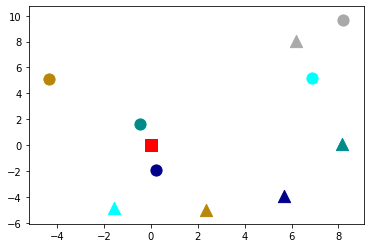

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

#x = list(map(lambda x: x[0], customers.values()))
#y = list(map(lambda x: x[1], customers.values()))
p, d = zip(*customers.values())
p_xs, p_ys = zip(*p)
d_xs, d_ys = zip(*d)

colors =  list(matplotlib.colors.cnames.keys())
plt.scatter(0, 0, marker=",", color="red", s=150)

for i in range(len(customers)):
    color = colors[i+20]
    p_x, p_y, d_x, d_y = p_xs[i], p_ys[i], d_xs[i], d_ys[i]
    #ピックアップ地点
    plt.scatter(p_x, p_y, marker=".", color=color, s=500)
    #デリバリー地点
    plt.scatter(d_x, d_y, marker="^", color=color, s=150)

print("あるリクエストに対し，●がピックアップ地点，▲がデリバリー地点")
plt.show()

# Constructive method

- Constructive methodでは，i分ごとにSimple insertion methodを行う．
- Simple insertion methodでは，tourにリクエストを挿入するのにかかるコストを元に，現在のtourにリクエストを挿入する．

In [71]:
class instance(customers):
    def __init__(self):
        self.n_customer = len(customers)
        self.tour = []
        self.objval = 0
    def solve(self):
        """
        i分ごとにSimple insertion methodを行う．
        inputs :
        outputs :
            None
        """
    def constructive(self):
        """
        Simple insertion methos
        inputs :
        outputs :
        """
        return tour